# Area and proportion calculations

This files is meant to calculate the interresting values to present in the results, like the % coverage of the important areas for krill mediated carbone sequestration (i.e., overlap between high krill density and efficient carbon sequestration).

## Load areas of cells

Particulary toward the poles, the cells of a regular grid in degres (here 2°x2°) have very different surface (km²). Thus, we used the OCIM data in which we also have the area of each cell.

In [2]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import scipy
import math
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


### Load OCIM data with area

In [3]:
# To be change with local directory of the data (file too heavy to be on git)
os.chdir('./Key_Areas_krill_carbon_sequestration/outputs_formated_data/')

# selct the formated file
OCIM = xr.open_dataset('fseq_OCIM2_48L_interpolated_SO.nc')
OCIM 

<xarray.Dataset>
Dimensions:        (ocean grid point: 405386, time: 1001, latitude: 20,
                    longitude: 180, depth: 48)
Coordinates:
  * longitude      (longitude) float64 -179.0 -177.0 -175.0 ... 177.0 179.0
  * depth          (depth) float64 4.935 14.88 25.12 ... 5.253e+03 5.582e+03
  * latitude       (latitude) int32 -79 -77 -75 -73 -71 ... -49 -47 -45 -43 -41
Dimensions without coordinates: ocean grid point, time
Data variables:
    fseq           (ocean grid point, time) float64 ...
    MASK           (latitude, longitude, depth) float64 ...
    LAT            (latitude, longitude, depth) float64 ...
    LON            (latitude, longitude, depth) float64 ...
    DEPTH          (latitude, longitude, depth) float64 ...
    VOL            (latitude, longitude, depth) float64 ...
    AREA           (latitude, longitude, depth) float64 ...
    mean_seq_time  (latitude, longitude, depth) float64 ...

## Area of cells in the study zone

The area of cell depends on latitude => this is stored for all cells (land and ocean) in 'AREA'
Then, the MASK is used to keep only the cells in the ocean (1 = ocean, 0= land, or proportion of the two)

Text(0.5, 1.0, 'Map of the area of the cells')

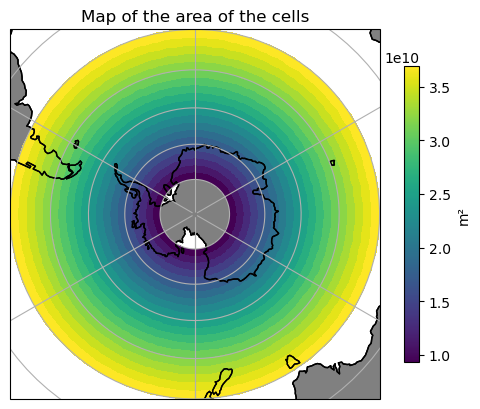

In [4]:
# select area
# note that the file is from -40°S
area = OCIM['AREA'].isel(depth=0) # area is in square meters

# Plot it
map_proj = ccrs.SouthPolarStereo()

p = area.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap="PuBu",
) 
p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'm²', shrink = 0.8)
plt.title('Map of the area of the cells')

Text(0.5, 1.0, 'Map of the area of the cells')

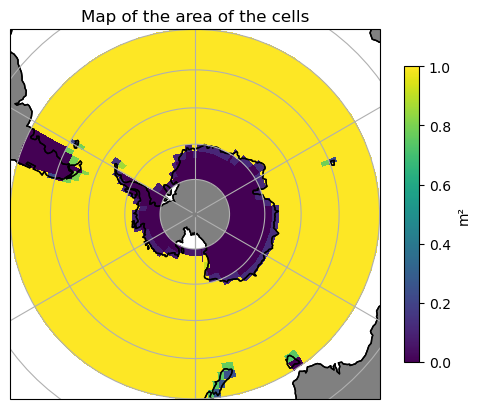

In [5]:
mask = OCIM['MASK'].isel(depth=20)

map_proj = ccrs.SouthPolarStereo()

p = mask.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap="PuBu",
) 
p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'm²', shrink = 0.8)
plt.title('Map of the area of the cells')

In [6]:
# transform area array into a dataframe and crop the file à -45°S
area_df = OCIM[['AREA', 'MASK']].isel(depth=0).to_dataframe().drop(['depth'], axis = 1).reset_index()
area_df = area_df[area_df['latitude'] <=-45].set_index(['latitude', 'longitude'])
area_df # 3240 rows

AREA      MASK
latitude longitude                        
-79      -179.0     9.332850e+09  0.061111
         -177.0     9.332850e+09  0.061111
         -175.0     9.332850e+09  0.061111
         -173.0     9.332850e+09  0.061111
         -171.0     9.332850e+09  0.061111
...                          ...       ...
-45       171.0     3.458337e+10  0.750000
          173.0     3.458337e+10  1.000000
          175.0     3.458337e+10  1.000000
          177.0     3.458337e+10  1.000000
          179.0     3.458337e+10  1.000000

[3240 rows x 2 columns]

In [7]:
## calculate the area of the ocean (remove land) => multiply be the proportion of the ocean in cell (= MASK : 1=ocean, 0=land, or %o each)
area_df['True_area'] = area_df['AREA']*area_df['MASK']
area_df # 3240  rows

AREA      MASK     True_area
latitude longitude                                      
-79      -179.0     9.332850e+09  0.061111  5.703408e+08
         -177.0     9.332850e+09  0.061111  5.703408e+08
         -175.0     9.332850e+09  0.061111  5.703408e+08
         -173.0     9.332850e+09  0.061111  5.703408e+08
         -171.0     9.332850e+09  0.061111  5.703408e+08
...                          ...       ...           ...
-45       171.0     3.458337e+10  0.750000  2.593752e+10
          173.0     3.458337e+10  1.000000  3.458337e+10
          175.0     3.458337e+10  1.000000  3.458337e+10
          177.0     3.458337e+10  1.000000  3.458337e+10
          179.0     3.458337e+10  1.000000  3.458337e+10

[3240 rows x 3 columns]

In [8]:
## total of the area considered in the study
# this is the total (arbitrary, following Green et al 2023) extent of the area considered 
# latitude goes from -80 to -40
tot_area = area_df['True_area'].sum() 
tot_area #  from -45°S it is 62773577241920.17 = 6277 e+10 m² = 6277 e+4 km²   from -40 it is 75343851660068.8 m² = 7534 e+10 m² = 7534 e+4 km² 

62773577241920.17

# Assign areas to the results data

In order to retrieve some interresting numbers of the coverage of high krill sequestration, area that overlapp intense fishing etc.. we first have to match these area to the results datasets.

To do this we use dataframes and joined them by coordinates.

In [9]:
# load results datasets
os.chdir('./Key_Areas_krill_carbon_sequestration/output_results/')

zones_krill_carbon = pd.read_csv('zones_krill_carbon.csv').set_index(['latitude', 'longitude'])

#all years
H_catch = pd.read_csv('H_catch.csv').set_index(['latitude', 'longitude'])

#Period1
H_catch_p1 = pd.read_csv('H_catch_p1.csv').set_index(['latitude', 'longitude'])

#period 2
H_catch_p2 = pd.read_csv('H_catch_p2.csv').set_index(['latitude', 'longitude'])

#period 3
H_catch_p3 = pd.read_csv('H_catch_p3.csv').set_index(['latitude', 'longitude'])

## calculate the area of each zones : carbon, krill, carbon&krill

In [10]:
# label = 1 are Htime seq + low/medium krill; label=2 are H krill and low/medium time seq and label=3 are H krill and H time seq
zones_krill_carbon = zones_krill_carbon.join(other = area_df, how = 'left')
zones_krill_carbon #2700 

label_grid  mean_seq_time  krill_adult_log  \
latitude longitude                                               
-75      -179              0.0     646.910548          0.92934   
         -177              0.0     601.882341          1.70806   
         -175              0.0     655.238074          1.24843   
         -173              0.0     641.075711          1.46391   
         -171              0.0     620.753036          1.66276   
...                        ...            ...              ...   
-47       171              0.0            NaN              NaN   
          173              0.0            NaN              NaN   
          175              0.0            NaN              NaN   
          177              0.0            NaN              NaN   
          179              0.0            NaN              NaN   

                    krill_catch_density_log  label          AREA  MASK  \
latitude longitude                                                       
-75      -179                           0.0    1.0  1.265922e+10   1.0   
         -177                           0.0    3.0  1.265922e+10   1.0   
         -175                           0.0    1.0  1.265922e+10   1.0   
         -173                           0.0    1.0  1.265922e+10   1.0   
         -171                           0.0    3.0  1.265922e+10   1.0   
...                                     ...    ...           ...   ...   
-47       171                           NaN    NaN  3.335547e+10   1.0   
          173                           NaN    NaN  3.335547e+10   1.0   
          175                           NaN    NaN  3.335547e+10   1.0   
          177                           NaN    NaN  3.335547e+10   1.0   
          179                           NaN    NaN  3.335547e+10   1.0   

                       True_area  
latitude longitude                
-75      -179       1.265922e+10  
         -177       1.265922e+10  
         -175       1.265922e+10  
         -173       1.265922e+10  
         -171       1.265922e+10  
...                          ...  
-47       171       3.335547e+10  
          173       3.335547e+10  
          175       3.335547e+10  
          177       3.335547e+10  
          179       3.335547e+10  

[2700 rows x 8 columns]

In [11]:
# total surface of the study area (here the area defined in 'zone_krill_carbon')
# = all the ocean with latitude from -75 to -51
tot_area_restricted = zones_krill_carbon['True_area'].sum()
tot_area_restricted # 56365167510303.7 m² 

56365167510303.7

In [12]:
# zone only high carbon seq but few/medium krill => label = 1
zones_C = zones_krill_carbon[zones_krill_carbon['label'] == 1]
area_C = zones_C['True_area'].sum() # 8743691815494.373  m²
prop_C = area_C/tot_area_restricted # 0.1551258020105414 

# zone only high krill => label = 2
zones_K = zones_krill_carbon[zones_krill_carbon['label'] == 2]
area_K = zones_K['True_area'].sum() # 3671315341347.0967  m²
prop_K = area_K/tot_area_restricted # 0.06513447051631613 

# zone both high carbon seq and high krill => label = 3
zones_KC = zones_krill_carbon[zones_krill_carbon['label'] == 3]
area_KC = zones_KC['True_area'].sum() # 7940290396993.851 m²
prop_KC = area_KC/tot_area_restricted  # 0.14087229307962837

In [13]:
print('carbon ', prop_C , 'krill ', prop_K, 'krill&carbon ', prop_KC)

carbon  0.1551258020105414 krill  0.06513447051631613 krill&carbon  0.14087229307962837


In [14]:
print('carbon ', area_C , 'krill ', area_K, 'krill&carbon ', area_KC)

carbon  8743691815494.373 krill  3671315341347.0967 krill&carbon  7940290396993.851


In [15]:
# same but total area of High krill - High Carbon (1+3 or 2+3)
zones_Cb = zones_krill_carbon[(zones_krill_carbon['label'] == 1) | (zones_krill_carbon['label'] == 3)]
area_Cb = zones_Cb['True_area'].sum() # 16683982212488.227  m²
prop_Cb = area_Cb/tot_area_restricted # 0.29599809509016983 

# zone only high krill => label = 2
zones_Kb = zones_krill_carbon[(zones_krill_carbon['label'] == 2) | (zones_krill_carbon['label'] == 3)]
area_Kb = zones_Kb['True_area'].sum() # 11611605738340.95 m²
prop_Kb = area_Kb/tot_area_restricted # 0.20600676359594455

In [16]:
print('carbon ', area_Cb , 'krill ', area_Kb)

carbon  16683982212488.227 krill  11611605738340.95


In [17]:
print('carbon ', prop_Cb , 'krill ', prop_Kb)

carbon  0.29599809509016983 krill  0.20600676359594455


In [18]:
# proportion of HKS in HK 
prop_hks_hk = area_KC/area_Kb # 0.683823630936366
#proportion of HKS in HS
prop_hks_hs = area_KC/area_Cb # 0.4759229718580266

In [19]:
prop_hks_hs

0.4759229718580266

## Calculate the area of the overlap with high fishing (COCA)

- the area of primary fishing grounds (for each period)
- the area of primary fishing grounds overlapping KAKS, High time seq zones (= the COCA), High krill biomass zones

In [20]:
# full period area_df
H_catch = H_catch.join(other = zones_krill_carbon, how = 'left')

# period 1
H_catch_p1 = H_catch_p1.join(other = zones_krill_carbon, how = 'left')

# period 2
H_catch_p2 = H_catch_p2.join(other = zones_krill_carbon, how = 'left')

# period 3
H_catch_p3 = H_catch_p3.join(other = zones_krill_carbon, how = 'left')

### Percentage of the total study area

In [21]:
# area and prop of the primary foshng grounds for the whole period (% of the study area)
area_Hcatch = H_catch['True_area'].sum()
prop_Hcatch = 100*area_Hcatch/tot_area_restricted

# idem for period 1
area_Hcatch_p1 = H_catch_p1['True_area'].sum()
prop_Hcatch_p1 = 100*area_Hcatch_p1/tot_area_restricted

# idem for period 2
area_Hcatch_p2 = H_catch_p2['True_area'].sum()
prop_Hcatch_p2 = 100*area_Hcatch_p2/tot_area_restricted

# idem for period 3
area_Hcatch_p3 = H_catch_p3['True_area'].sum()
prop_Hcatch_p3 = 100*area_Hcatch_p3/tot_area_restricted

In [22]:
print( area_Hcatch, prop_Hcatch, area_Hcatch_p1, prop_Hcatch_p1, area_Hcatch_p2, prop_Hcatch_p2, area_Hcatch_p3, prop_Hcatch_p3)

2012001040096.2295 3.569582295179785 1967591702447.7595 3.4907936751684066 617834815914.3066 1.0961287674721534 514219981210.5321 0.9123009899980007


### Overlap between the high fishing grounds and the different categories (including the COCA)

In [23]:
# Areas of the overlap berween the primary fishing grounds and each categories (zones types) + btw all the area of High time seq (= COCA)
# all years
overlap_HFxKAKS = H_catch[H_catch['label'] == 3]
overlap_HFxHC = H_catch[H_catch['label'] == 1]
overlap_HF = H_catch[H_catch['label'] == 2]

COCA = H_catch[(H_catch['label'] == 1) | (H_catch['label'] == 3)]

# period 1
overlap_HFxKAKS_p1 = H_catch_p1[H_catch_p1['label'] == 3]
overlap_HFxHC_p1 = H_catch_p1[H_catch_p1['label'] == 1]
overlap_HF_p1 = H_catch_p1[H_catch_p1['label'] == 2]

COCA_p1 = H_catch_p1[(H_catch_p1['label'] == 1) | (H_catch_p1['label'] == 3)]
# period 2
overlap_HFxKAKS_p2 = H_catch_p2[H_catch_p2['label'] == 3]
overlap_HFxHC_p2 = H_catch_p2[H_catch_p2['label'] == 1]
overlap_HF_p2 = H_catch_p2[H_catch_p2['label'] == 2]

COCA_p2 = H_catch_p2[(H_catch_p2['label'] == 1) | (H_catch_p2['label'] == 3)]
# period 3
overlap_HFxKAKS_p3 = H_catch_p3[H_catch_p3['label'] == 3]
overlap_HFxHC_p3 = H_catch_p3[H_catch_p3['label'] == 1]
overlap_HF_p3 = H_catch_p3[H_catch_p3['label'] == 2]

COCA_p3 = H_catch_p3[(H_catch_p3['label'] == 1) | (H_catch_p3['label'] == 3)]

In [24]:
#all years
area_overlap_HFxKAKS = overlap_HFxKAKS['True_area'].sum()
prop_overlap_HFxKAKS = 100*area_overlap_HFxKAKS/area_KC

area_overlap_HFxHC = overlap_HFxHC['True_area'].sum()
prop_overlap_HFxHC = 100*area_overlap_HFxHC/area_C

area_overlap_HF = overlap_HF['True_area'].sum()

area_COCA = COCA['True_area'].sum()
prop_COCA = 100*area_COCA/area_Cb # 7.3 %
prop_COCA_SO = 100*area_COCA/tot_area_restricted # 2.2%

#p1
area_overlap_HFxKAKS_p1 = overlap_HFxKAKS_p1['True_area'].sum()
prop_overlap_HFxKAKS_p1 = 100*area_overlap_HFxKAKS_p1/area_KC

area_overlap_HFxHC_p1 = overlap_HFxHC_p1['True_area'].sum()
prop_overlap_HFxHC_p1 = 100*area_overlap_HFxHC_p1/area_C

area_overlap_HF_p1 = overlap_HF_p1['True_area'].sum()

area_COCA_p1 = COCA_p1['True_area'].sum()
prop_COCA_p1 = 100*area_COCA_p1/area_Cb # 7%
prop_COCA_p1_SO = 100*area_COCA_p1/tot_area_restricted # 2.1%

#p2
area_overlap_HFxKAKS_p2 = overlap_HFxKAKS_p2['True_area'].sum()
prop_overlap_HFxKAKS_p2 = 100*area_overlap_HFxKAKS_p2/area_KC

area_overlap_HFxHC_p2 = overlap_HFxHC_p2['True_area'].sum()
prop_overlap_HFxHC_p2 = 100*area_overlap_HFxHC_p2/area_C

area_overlap_HF_p2 = overlap_HF_p2['True_area'].sum()

area_COCA_p2 = COCA_p2['True_area'].sum()
prop_COCA_p2 = 100*area_COCA_p2/area_Cb # 1.55%
prop_COCA_p2_SO = 100*area_COCA_p2/tot_area_restricted # 0.46 %

#p3
area_overlap_HFxKAKS_p3 = overlap_HFxKAKS_p3['True_area'].sum()
prop_overlap_HFxKAKS_p3 = 100*area_overlap_HFxKAKS_p3/area_KC

area_overlap_HFxHC_p3 = overlap_HFxHC_p3['True_area'].sum()
prop_overlap_HFxHC_p3 = 100*area_overlap_HFxHC_p3/area_C

area_overlap_HF_p3 = overlap_HF_p3['True_area'].sum()

area_COCA_p3 = COCA_p3['True_area'].sum()
prop_COCA_p3 = 100*area_COCA_p3/area_Cb # 1.6%
prop_COCA_p3_SO = 100*area_COCA_p3/tot_area_restricted # 0.47 %

In [25]:
# prop of high fishig grounds in KAKS (orange zones)
print(prop_overlap_HFxKAKS, prop_overlap_HFxKAKS_p1, prop_overlap_HFxKAKS_p2, prop_overlap_HFxKAKS_p3)
# prop of high fishign grounds in blue zones (high carbon only)
print(prop_overlap_HFxHC, prop_overlap_HFxHC_p1, prop_overlap_HFxHC_p2, prop_overlap_HFxHC_p3)

8.858715853686576 8.57907030278026 2.7059058599099046 1.8290044449055178
5.882142061588213 5.628191335821705 0.5079014515330176 1.400293908784578


In [26]:
# nb for COCA ie. high fishing grounds in all "high time seq" areas (= orange + blue)
print(area_COCA, area_COCA_p1, area_COCA_p2, area_COCA_p3) 
print(prop_COCA, prop_COCA_p1, prop_COCA_p2, prop_COCA_p3)
print(prop_COCA_SO, prop_COCA_p1_SO, prop_COCA_p2_SO, prop_COCA_p3_SO) 

1217724138242.0874 1173314800593.6177 259266120794.58963 267665648194.68695
7.298761906678379 7.03258242336996 1.5539822417247893 1.6043271012021036
2.1604196208934963 2.0816310008821186 0.45997578335448946 0.47487776585735675


In [71]:
area_COCA_p2 / area_COCA_p1 # 22%
area_COCA_p3 / area_COCA_p1 #  23%

0.2209689340519855

# Calculate the area of the overlap with MPA

Here calculate the proportion the overlap between krill and carbon and the MAP real or in project.
To do this we calculate the area of the cells that are inside the different MPA and compare it with each MPA's area found in the litterature.
This could generate big approximation as the cells are 2°x2° and are considred 'in' the MPA if the center of the cell touches the MPA or is inside.

In [27]:
# load results datasets
os.chdir('./Key_Areas_krill_carbon_sequestration/output_results/')

SOrkney_mpa = pd.read_csv('SOrkney_mpa.csv').set_index(['latitude', 'longitude'])
Ross_mpa = pd.read_csv('Ross_mpa.csv').set_index(['latitude', 'longitude'])

#load the mpa data
os.chdir('./Key_Areas_krill_carbon_sequestration/data_envir/MPA')
MPAs = gpd.read_file('mpasPolygon.shp')
MPAs[['GAR_Name', 'GAR_Size']]

,GAR_Name,GAR_Size
0,MPA RS-GPZi,1555850.51
1,MPA RS-GPZii,74765.21
2,MPA RS-GPZiii,21097.81
3,MPA RS-KRZ,328750.16
4,MPA RS-SRZ,109563.21
5,MPA SO-SS,93750.79


In [28]:
MPAs[['GAR_Name', 'GAR_Size']]

,GAR_Name,GAR_Size
0,MPA RS-GPZi,1555850.51
1,MPA RS-GPZii,74765.21
2,MPA RS-GPZiii,21097.81
3,MPA RS-KRZ,328750.16
4,MPA RS-SRZ,109563.21
5,MPA SO-SS,93750.79


In [29]:
area_df = area_df.reset_index()
area_df = area_df[area_df['latitude'] <=-45].set_index(['latitude', 'longitude'])
area_df #2700 

AREA      MASK     True_area
latitude longitude                                      
-79      -179.0     9.332850e+09  0.061111  5.703408e+08
         -177.0     9.332850e+09  0.061111  5.703408e+08
         -175.0     9.332850e+09  0.061111  5.703408e+08
         -173.0     9.332850e+09  0.061111  5.703408e+08
         -171.0     9.332850e+09  0.061111  5.703408e+08
...                          ...       ...           ...
-45       171.0     3.458337e+10  0.750000  2.593752e+10
          173.0     3.458337e+10  1.000000  3.458337e+10
          175.0     3.458337e+10  1.000000  3.458337e+10
          177.0     3.458337e+10  1.000000  3.458337e+10
          179.0     3.458337e+10  1.000000  3.458337e+10

[3240 rows x 3 columns]

In [30]:
SOrkney_mpa = SOrkney_mpa.join(other = area_df, how = 'left')
Ross_mpa = Ross_mpa.join(other = area_df, how = 'left')

In [31]:
SOrkney_mpa

label  Protection_status          AREA  MASK     True_area
latitude longitude                                                            
-63.0    -47.0        3.0  SOrkney_protected  2.220467e+10   1.0  2.220467e+10
         -45.0        1.0  SOrkney_protected  2.220467e+10   1.0  2.220467e+10
         -43.0        1.0  SOrkney_protected  2.220467e+10   1.0  2.220467e+10
         -41.0        1.0  SOrkney_protected  2.220467e+10   1.0  2.220467e+10

In [32]:
SOrkney_area = SOrkney_mpa['True_area'].sum()*0.000001 
Ross_area = Ross_mpa['True_area'].sum()*0.000001 
print(SOrkney_area, Ross_area) # 88818.67529693915 ; 959390.1589959601

88818.67529693915 959390.1589959601


### overlap of KAKS with MPAs

In [33]:
Ross_KC = Ross_mpa[Ross_mpa['label'] == 3]
Ross_KC = Ross_KC['True_area'].sum()*0.000001
Ross_KC # 271529.7374434401 

271529.7374434401

In [34]:
SOrkney_KC = SOrkney_mpa[SOrkney_mpa['label'] == 3]
SOrkney_KC = SOrkney_KC['True_area'].sum()*0.000001
SOrkney_KC # 22204.66882423479

22204.66882423479

In [35]:
# calculate the proportion of high K and C in the MPA
prop_Sorkney = 100*SOrkney_KC/MPAs['GAR_Size'][5] # 23.68 % 
prop_Ross = 100*Ross_KC/(MPAs['GAR_Size'][0] + MPAs['GAR_Size'][1] + MPAs['GAR_Size'][2] + MPAs['GAR_Size'][4]) # 15.4 %

In [36]:
prop_Sorkney
prop_Ross

15.416642443335743

#### ovelrap of all high time seq areas with MPAs

In [37]:
Ross_allC = Ross_mpa[(Ross_mpa['label'] == 3) | (Ross_mpa['label'] == 1)]
Ross_allC = Ross_allC['True_area'].sum()*0.000001
Ross_allC # 742283.6745683267

742283.6745683267

In [38]:
SOrkney_allC = SOrkney_mpa[(SOrkney_mpa['label'] == 3) | (SOrkney_mpa['label'] == 1)]
SOrkney_allC = SOrkney_allC['True_area'].sum()*0.000001
SOrkney_allC # 88818.67529693915

88818.67529693915

In [39]:
SOrkney_allC = SOrkney_mpa[(SOrkney_mpa['label'] == 3) | (SOrkney_mpa['label'] == 1)]
SOrkney_allC = SOrkney_allC['True_area'].sum()*0.000001
SOrkney_allC # 88818.67529693915

In [39]:
# calculate the proportion of high C tome seq in the MPA
prop_SorkneyC = 100*SOrkney_allC/MPAs['GAR_Size'][5] # 94.7 % 
prop_RossC = 100*Ross_allC/(MPAs['GAR_Size'][0] + MPAs['GAR_Size'][1] + MPAs['GAR_Size'][2] + MPAs['GAR_Size'][4]) # 42.1 %

In [40]:
prop_SorkneyC
prop_RossC

42.1446362011416

#### Blue zones with MPAs

In [63]:
Ross_HC = Ross_mpa[Ross_mpa['label'] == 1]
Ross_HC = Ross_HC['True_area'].sum()*0.000001
Ross_HC # 470753.9371248865

SOrkney_HC = SOrkney_mpa[SOrkney_mpa['label'] == 1]
SOrkney_HC = SOrkney_HC['True_area'].sum()*0.000001
SOrkney_HC # 66614.00647270438

66614.00647270438

In [65]:
# calculate the proportion of high C tome seq in the MPA
prop_SorkneyHC = 100*SOrkney_HC/MPAs['GAR_Size'][5] # 71.1 % 
prop_RossHC = 100*Ross_HC/(MPAs['GAR_Size'][0] + MPAs['GAR_Size'][1] + MPAs['GAR_Size'][2] + MPAs['GAR_Size'][4]) # 26.7 %

In [67]:
prop_SorkneyHC
prop_RossHC

71.05434148630042

### How much of the K&C zones (orange zones) is under protection ? 

In [41]:
KC_prop_protected = (100*(Ross_KC + SOrkney_KC))/(area_KC*0.000001)
KC_prop_protected # 3.7 %

3.69929047404716

In [42]:
# compared to the protection level pf the SO in general (taken from the restricted zone)
prop_protection = 100*(MPAs['GAR_Size'][0] +MPAs['GAR_Size'][1] + MPAs['GAR_Size'][2] + MPAs['GAR_Size'][4])/(tot_area_restricted*0.000001)
prop_protection # 3.1%

3.1247609433220154

### How much of the hig time seq zones (blue zones or blue + orange) is under protection ? 

In [43]:
# all H seq zones (blue + orange)
KC_prop_protectedC = (100*(Ross_allC + SOrkney_allC))/(area_Cb*0.000001)
KC_prop_protectedC # 4.98 %

4.981438719367445

In [68]:
# only bleu zones
HC_prop_protected = (100*(Ross_HC + SOrkney_HC))/(area_C*0.000001)
HC_prop_protected # 6.1 %

6.145778636037252

# how much would be protected with the Weddell Sea MPA as proposed

In [44]:
# load results datasets
os.chdir('./Key_Areas_krill_carbon_sequestration/output_results/')

Weddell_mpa = pd.read_csv('Weddell_mpa.csv').set_index(['latitude', 'longitude'])
Weddell_mpa # 83 rows

label  Protection_status
latitude longitude                          
-65.0    -59.0        0.0  Weddell_protected
         -57.0        0.0  Weddell_protected
         -55.0        0.0  Weddell_protected
         -53.0        1.0  Weddell_protected
         -51.0        1.0  Weddell_protected
...                   ...                ...
-75.0    -35.0        3.0  Weddell_protected
         -33.0        3.0  Weddell_protected
         -31.0        3.0  Weddell_protected
         -29.0        3.0  Weddell_protected
         -27.0        2.0  Weddell_protected

[83 rows x 2 columns]

In [45]:
# Add the areas to the Weddell sea mpa cells
Weddell_mpa = Weddell_mpa.join(other = area_df, how = 'left')
Weddell_mpa

label  Protection_status          AREA  MASK     True_area
latitude longitude                                                            
-65.0    -59.0        0.0  Weddell_protected  2.067035e+10   1.0  2.067035e+10
         -57.0        0.0  Weddell_protected  2.067035e+10   1.0  2.067035e+10
         -55.0        0.0  Weddell_protected  2.067035e+10   1.0  2.067035e+10
         -53.0        1.0  Weddell_protected  2.067035e+10   1.0  2.067035e+10
         -51.0        1.0  Weddell_protected  2.067035e+10   1.0  2.067035e+10
...                   ...                ...           ...   ...           ...
-75.0    -35.0        3.0  Weddell_protected  1.265922e+10   1.0  1.265922e+10
         -33.0        3.0  Weddell_protected  1.265922e+10   1.0  1.265922e+10
         -31.0        3.0  Weddell_protected  1.265922e+10   1.0  1.265922e+10
         -29.0        3.0  Weddell_protected  1.265922e+10   1.0  1.265922e+10
         -27.0        2.0  Weddell_protected  1.265922e+10   1.0  1.265922e+10

[83 rows x 5 columns]

In [46]:
area_KAKS_Weddell = Weddell_mpa[Weddell_mpa['label'] == 3]['True_area'].sum()# *0.000001
tot_area_Weddell = Weddell_mpa['True_area'].sum()
prop_KAKS = area_KAKS_Weddell/tot_area_Weddell
prop_KAKS # 0.668 

0.6678016954136213

In [47]:
area_HS_Weddell = Weddell_mpa[Weddell_mpa['label'] == 1]['True_area'].sum()# *0.000001
tot_area_Weddell = Weddell_mpa['True_area'].sum()
prop_HS = area_HS_Weddell/tot_area_Weddell
prop_HS # 0.16

0.16264250600928978

In [48]:
area_HK_Weddell = Weddell_mpa[Weddell_mpa['label'] == 2]['True_area'].sum()# *0.000001
tot_area_Weddell = Weddell_mpa['True_area'].sum()
prop_HK = area_HK_Weddell/tot_area_Weddell
prop_HK # 0.085

0.08530053276216246

In [49]:
area_0_Weddell = Weddell_mpa[Weddell_mpa['label'] == 0]['True_area'].sum()# *0.000001
tot_area_Weddell = Weddell_mpa['True_area'].sum()
prop_0 = area_0_Weddell/tot_area_Weddell
prop_0 # 0.084

0.08425526581492647

In [55]:
# how much of the KAKS this MPA would protect ?
KC_prop_protected_by_weddell = (100*(area_KAKS_Weddell))/(area_KC)
KC_prop_protected_by_weddell # 2.8 %

11.43258862368163

In [56]:
# how much of the Hseq this MPA would protect ?
C_prop_protected_by_weddell = (100*(area_HS_Weddell))/(area_Cb)
C_prop_protected_by_weddell # 1.3 %

1.3251583715127055

In [57]:
# how much of the Hkrill this MPA would protect ?
K_prop_protected_by_weddell = (100*(area_HK_Weddell))/(area_Kb)
K_prop_protected_by_weddell # 1 %

0.9986030948060249

### To what protection % the KAKS would reach with the Weddell Sea MPA + for H time seq 

In [84]:
KC_prop_protected_with_weddell = (100*(Ross_KC + SOrkney_KC + area_KAKS_Weddell*0.000001))/(area_KC*0.000001)
KC_prop_protected_with_weddell # 15.1 %

15.131879097728792

In [60]:
C_prop_protected_with_weddell = (100*(Ross_allC + SOrkney_allC + area_HS_Weddell*0.000001))/(area_Cb*0.000001)
C_prop_protected_with_weddell # 6.3 %

6.30659709088015

## What is the areas of the catch on each period
To see the concentration of catches: total areas fished in each period

In [85]:
os.chdir('./Key_Areas_krill_carbon_sequestration/outputs_formated_data/')
# load the catch data 
catch_p1 = pd.read_csv('Krill_catch_final_1.csv').set_index(['latitude', 'longitude']).dropna()
catch_p2 = pd.read_csv('Krill_catch_final_2.csv').set_index(['latitude', 'longitude']).dropna()
catch_p3 = pd.read_csv('Krill_catch_final_3.csv').set_index(['latitude', 'longitude']).dropna()

In [86]:
#join the areas
catch_p1 = catch_p1.join(area_df , how='left')
catch_p2 = catch_p2.join(area_df , how='left')
catch_p3 = catch_p3.join(area_df , how='left')

In [87]:
# sum the area to get the total area fished in eahc period
area_fished1 = catch_p1.sum()['True_area']*0.000001 # 4,600,054.005471619 km²
area_fished2 = catch_p2.sum()['True_area']*0.000001 # 1,034,650.1718364782 km²
area_fished3 = catch_p3.sum()['True_area']*0.000001 # 1,012,877.9730397434 km²

In [88]:
print(area_fished1, area_fished2, area_fished3)

4600054.005471619 1034650.1718364782 1012877.9730397434


In [43]:
area_fished3/area_fished1

0.220188278623459